In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"negarmansouri96","key":"dff6cfe0d2006e749b7c718a13c89eef"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d engraqeel/iot23preprocesseddata

Dataset URL: https://www.kaggle.com/datasets/engraqeel/iot23preprocesseddata
License(s): unknown
 99% 181M/183M [00:04<00:00, 59.5MB/s]
100% 183M/183M [00:04<00:00, 42.5MB/s]


In [5]:
import zipfile
import os
import pandas as pd
import re

zip_file_path = "/content/iot23preprocesseddata.zip"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('extracted_files')

In [6]:
folder_path = '/content/extracted_files'

csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

combined_df = pd.DataFrame()

for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    combined_df = pd.concat([combined_df, df], ignore_index=True)


print("number of categories:", len(set(combined_df['label'])))
print("categories:", set(combined_df['label']))
print("category count:", combined_df['label'].value_counts())

<ipython-input-6-bc620a1cd13f>:9: DtypeWarning: Columns (9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


number of categories: 13
categories: {'FileDownload', 'C&C-Torii', 'C&C-HeartBeat', 'C&C', 'C&C-HeartBeat-FileDownload', 'C&C-Mirai', 'DDoS', 'Okiru-Attack', 'Benign', 'Okiru', 'PartOfAHorizontalPortScan', 'C&C-FileDownload', 'Attack'}
category count: label
PartOfAHorizontalPortScan     3389036
Okiru                         1313012
Benign                         688812
DDoS                           638506
C&C                             15286
C&C-HeartBeat                    1332
Attack                            538
C&C-FileDownload                   46
C&C-Torii                          30
FileDownload                       13
C&C-HeartBeat-FileDownload          8
Okiru-Attack                        3
C&C-Mirai                           1
Name: count, dtype: int64


In [7]:
class_mapping = {
    'DDoS': 'DDoS',
    'Benign': 'Benign',
    'PartOfAHorizontalPortScan': 'PortScan',
    'Okiru': 'Okiru',
    'C&C-HeartBeat': 'C&C',
    'C&C': 'C&C',
    'C&C-Mirai': 'C&C',
    'C&C-Torii': 'C&C',
    'C&C-PartOfAHorizontalPortScan': 'C&C',
    'C&C-FileDownload': 'C&C',
    'C&C-HeartBeat-FileDownload': 'C&C',
    'Okiru-Attack': 'Okiru',
}

combined_df['merged_label'] = combined_df['label'].map(class_mapping)

combined_df = combined_df.dropna(subset=['merged_label'])

merged_category_counts = combined_df['merged_label'].value_counts()

print("Counts of merged categories:")
print(merged_category_counts)


Counts of merged categories:
merged_label
PortScan    3389036
Okiru       1313015
Benign       688812
DDoS         638506
C&C           16703
Name: count, dtype: int64


In [8]:
combined_df.describe()

,Unnamed: 0,ts,id.orig_p,id.resp_p,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
count,6.046072e+06,6.046072e+06,6.046072e+06,6.046072e+06,6.046072e+06,6.046072e+06,6.046072e+06,6.046072e+06,6.046072e+06
mean,2.481269e+05,1.546218e+09,3.603472e+04,1.897729e+04,5.018928e-02,4.375867e+01,1.907419e+03,5.796292e-02,6.369185e+01
std,1.453386e+05,9.546425e+06,1.776951e+04,2.273152e+04,2.104297e+01,3.534379e+04,1.392853e+06,9.775121e+01,1.422849e+05
min,0.000000e+00,1.532101e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.220840e+05,1.537539e+09,2.256800e+04,2.300000e+01,0.000000e+00,1.000000e+00,4.000000e+01,0.000000e+00,0.000000e+00
50%,2.480550e+05,1.545426e+09,3.618200e+04,8.081000e+03,0.000000e+00,1.000000e+00,4.000000e+01,0.000000e+00,0.000000e+00
75%,3.740250e+05,1.551383e+09,5.083800e+04,3.721500e+04,0.000000e+00,2.000000e+00,8.000000e+01,0.000000e+00,0.000000e+00
max,4.999980e+05,1.569018e+09,6.553500e+04,6.549000e+04,2.027200e+04,6.602735e+07,1.914793e+09,2.394840e+05,3.496187e+08


In [9]:
print(combined_df['merged_label'].isnull().sum())


0


In [10]:
from sklearn.utils import resample

df_benign = combined_df[combined_df['merged_label'] == 'Benign']
df_ddos = combined_df[combined_df['merged_label'] == 'DDoS']
df_portscan = combined_df[combined_df['merged_label'] == 'PortScan']
df_cnc = combined_df[combined_df['merged_label'] == 'C&C']
df_okiru = combined_df[combined_df['merged_label'] == 'Okiru']

min_samples = 16000
df_ddos_downsampled = resample(df_ddos, replace=False, n_samples=min_samples, random_state=42)
df_portscan_downsampled = resample(df_portscan, replace=False, n_samples=min_samples, random_state=42)
df_cnc_downsampled = resample(df_cnc, replace=False, n_samples=min_samples, random_state=42)
df_okiru_downsampled = resample(df_okiru, replace=False, n_samples=min_samples, random_state=42)
df_benign_downsampled = resample(df_benign, replace=False, n_samples=min_samples, random_state=42)

balanced_df = pd.concat([ df_benign_downsampled, df_ddos_downsampled, df_portscan_downsampled,
                         df_cnc_downsampled, df_okiru_downsampled])


In [11]:
merged_category_counts = balanced_df['merged_label'].value_counts()

print("Counts of merged categories:")
print(merged_category_counts)

Counts of merged categories:
merged_label
Benign      16000
DDoS        16000
PortScan    16000
C&C         16000
Okiru       16000
Name: count, dtype: int64


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tqdm import tqdm
import pandas as pd


features = balanced_df.drop(columns=['label', 'merged_label'])
labels = balanced_df['merged_label']

categorical_columns = features.select_dtypes(include=['object']).columns
label_encoders = {}

for column in categorical_columns:
    le = LabelEncoder()
    features[column] = le.fit_transform(features[column].astype(str))
    label_encoders[column] = le

# Drop columns with null values
features = features.dropna(axis=1)



label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)


# Create a label mapping between original labels and encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))



scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

n_estimators = 100
rf = RandomForestClassifier(n_estimators=1, warm_start=True, random_state=42, n_jobs=-1)

for i in tqdm(range(1, n_estimators + 1), desc="Building Trees"):
    rf.set_params(n_estimators=i)
    rf.fit(scaled_features, encoded_labels)

importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': features.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


top_18_features = feature_importance_df.head(18)['Feature'].values



selected_features_df = pd.DataFrame(scaled_features, columns=features.columns)[top_18_features]
final_data = pd.concat([selected_features_df, pd.DataFrame(encoded_labels, columns=['encoded_label'])], axis=1)

top_18_features, final_data.head(), label_mapping


Building Trees: 100%|██████████| 100/100 [00:13<00:00,  7.69it/s]


(array(['id.resp_p', 'ts', 'orig_ip_bytes', 'id.orig_h', 'Unnamed: 0',
        'id.orig_p', 'orig_pkts', 'id.resp_h', 'conn_state', 'history',
        'duration', 'orig_bytes', 'resp_bytes', 'resp_pkts', 'proto',
        'service', 'resp_ip_bytes', 'uid'], dtype=object),
    id.resp_p        ts  orig_ip_bytes  id.orig_h  Unnamed: 0  id.orig_p  \
 0  -0.898858 -0.091571      -0.003978  -0.616079    0.409689   0.616996   
 1  -0.898858 -0.091661      -0.003864  -0.616079   -0.204026   0.034825   
 2  -0.898858 -0.091718      -0.003978  -0.616079   -0.594067   0.187159   
 3  -0.898858 -0.091801      -0.003978  -0.616079   -1.163873   0.406820   
 4  -0.898858 -0.091603      -0.003978  -0.616079    0.192516  -0.116104   
 
    orig_pkts  id.resp_h  conn_state   history  duration  orig_bytes  \
 0  -0.003695  -1.619064    0.382335  0.023601 -0.516599   -0.187693   
 1  -0.003640   0.532437    0.382335  0.023601  1.873243   -0.099908   
 2  -0.003695   2.211121    0.382335  0.023601 -0.5165

In [13]:
final_data.shape

(80000, 19)

In [14]:
print(final_data.describe())

          id.resp_p            ts  orig_ip_bytes     id.orig_h    Unnamed: 0  \
count  8.000000e+04  8.000000e+04   8.000000e+04  8.000000e+04  8.000000e+04   
mean  -2.273737e-17 -1.807621e-14  -5.329071e-19 -1.023182e-16 -3.410605e-17   
std    1.000006e+00  1.000006e+00   1.000006e+00  1.000006e+00  1.000006e+00   
min   -8.997844e-01 -1.251143e+00  -4.034694e-03 -9.243680e+00 -1.262747e+00   
25%   -8.988576e-01 -8.915362e-01  -3.996708e-03 -9.036657e-01 -1.039099e+00   
50%   -6.311148e-01 -9.157353e-02  -3.977715e-03 -3.284923e-01 -7.821262e-02   
75%    5.999218e-01  5.995981e-02  -3.958722e-03  1.109441e+00  8.833015e-01   
max    1.709459e+00  1.966302e+00   2.807845e+02  8.586695e+00  1.835555e+00   

          id.orig_p     orig_pkts     id.resp_h    conn_state       history  \
count  8.000000e+04  8.000000e+04  8.000000e+04  8.000000e+04  8.000000e+04   
mean   4.547474e-17 -2.664535e-19 -1.222134e-16 -1.421085e-16 -4.121148e-17   
std    1.000006e+00  1.000006e+00  1.00000

In [15]:
print(final_data['encoded_label'].value_counts())


encoded_label
0    16000
2    16000
4    16000
1    16000
3    16000
Name: count, dtype: int64


In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances_argmin_min
import numpy as np


features = final_data.drop(columns=['encoded_label'])
labels = final_data['encoded_label']

scaler = MinMaxScaler(feature_range=(0, 255))
scaled_features = scaler.fit_transform(features)


agg_cluster = AgglomerativeClustering(n_clusters=6, metric='euclidean', linkage='ward')
cluster_labels = agg_cluster.fit_predict(scaled_features.T)

# Step 4: Find Centroids and 3 Closest Features for Each Cluster
cluster_centroids = []
cluster_indices = []

for cluster_idx in range(6):
    # Get the features in this cluster
    cluster_features = scaled_features.T[cluster_labels == cluster_idx]

    # Calculate the centroid of the cluster
    cluster_centroid = np.mean(cluster_features, axis=0)  # Already a NumPy array

    # Find the 3 closest features to the centroid
    closest_indices, _ = pairwise_distances_argmin_min(
        cluster_features, cluster_centroid.reshape(1, -1)
    )

    closest_3 = closest_indices[:3] if len(closest_indices) >= 3 else np.pad(closest_indices, (0, 3 - len(closest_indices)), constant_values=-1)
    cluster_indices.append(closest_3)

image_dataset = []
image_labels = []

for i in range(scaled_features.shape[0]):
    feature_row = scaled_features[i, :]
    rgb_image = np.zeros((2, 3, 3))

    for cluster_idx, feature_indices in enumerate(cluster_indices):
        x = cluster_idx // 3  # Row index in 2x3 grid
        y = cluster_idx % 3   # Column index in 2x3 grid

        for channel, feature_index in enumerate(feature_indices):
            if feature_index != -1:  # Ensure valid indices
                rgb_image[x, y, channel] = feature_row[feature_index]

    image_dataset.append(rgb_image)
    image_labels.append(labels.iloc[i])

image_dataset = np.array(image_dataset)
image_labels = np.array(image_labels)

print(f"Image dataset shape: {image_dataset.shape}")
print(f"Label dataset shape: {image_labels.shape}")


Image dataset shape: (80000, 2, 3, 3)
Label dataset shape: (80000,)


In [17]:
print(len(set(image_labels)))
print(set(image_labels))
print(label_mapping)

5
{0, 1, 2, 3, 4}
{'Benign': 0, 'C&C': 1, 'DDoS': 2, 'Okiru': 3, 'PortScan': 4}


In [ ]:
label_counts = pd.Series(image_labels).value_counts()

print(label_counts)

0    16000
2    16000
4    16000
1    16000
3    16000
Name: count, dtype: int64


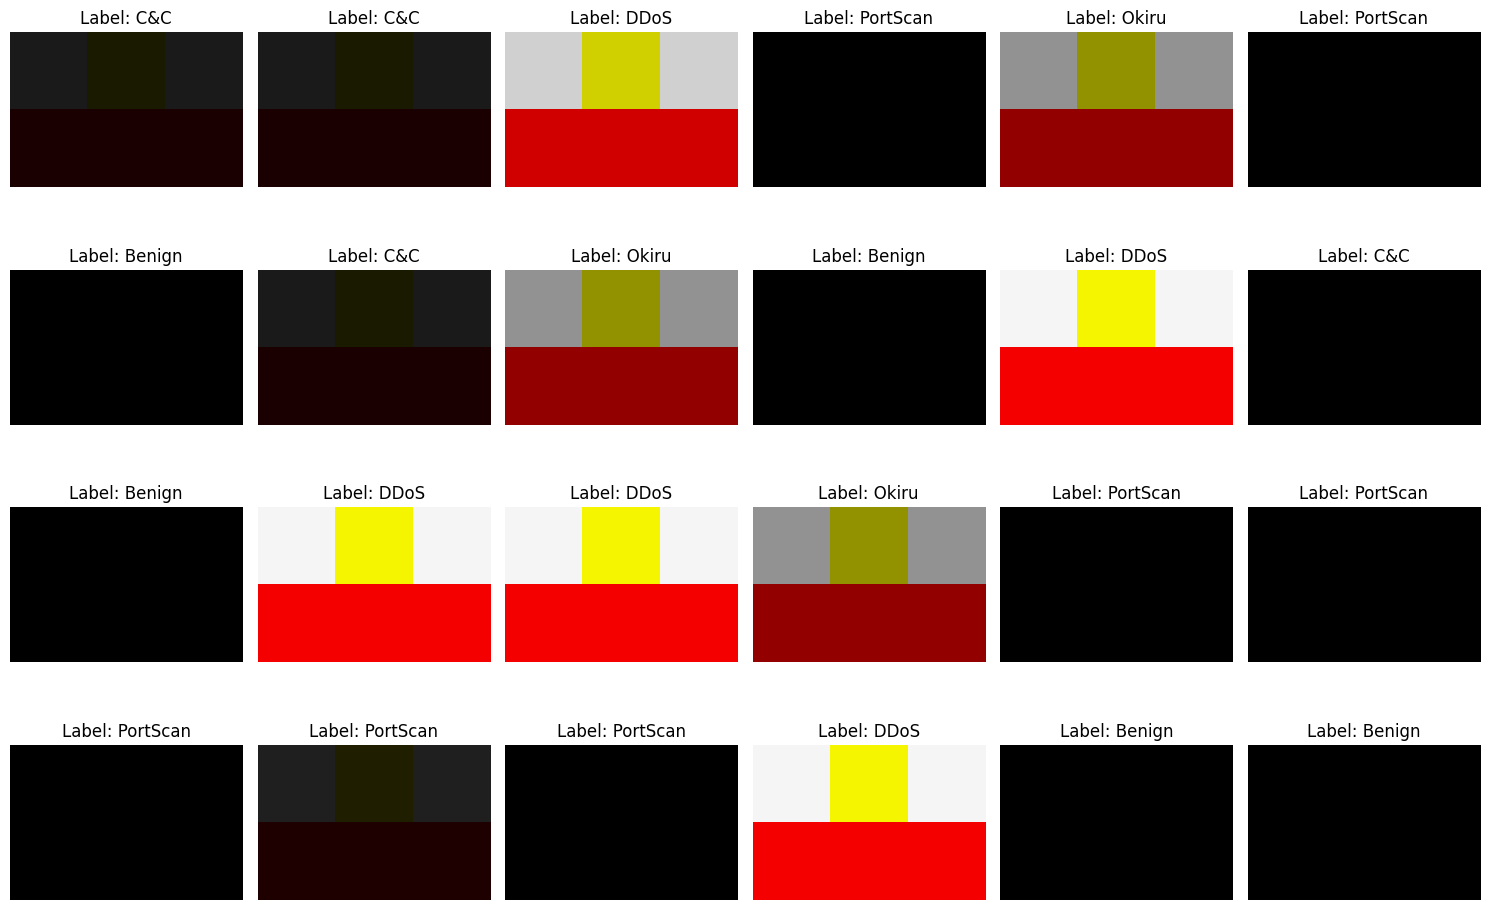

In [18]:
import matplotlib.pyplot as plt

def show_random_images(image_dataset, image_labels, categories, num_samples=24):
    indices = np.random.choice(len(image_dataset), num_samples, replace=False)
    selected_images = image_dataset[indices]
    selected_labels = image_labels[indices]


    fig, axes = plt.subplots(4, 6, figsize=(15, 10))


    axes = axes.flatten()


    for i in range(num_samples):
        img = selected_images[i]
        label = selected_labels[i]


        axes[i].imshow(img.astype(np.uint8))  # Convert to uint8 for display
        axes[i].set_title(f'Label: {categories[label]}')
        axes[i].axis('off')  # Turn off the axis for a cleaner display


    for j in range(num_samples, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


categories = {v: k for k, v in label_mapping.items()}


show_random_images(image_dataset, image_labels, categories)

Model: "Optimized_CNN_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2, 3, 3)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_32_1 (Conv2D)                 │ (None, 2, 3, 32)            │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_32_1 (BatchNormalization)  │ (None, 2, 3, 32)            │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_64 (Conv2D)                   │ (None, 1, 2, 64)            │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_64 (BatchNormalization)    │ (None, 1, 2, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_128 (Dense)                    │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_128 (BatchNormalization)   │ (None, 128)                 │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_128 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Classifier_Output (Dense)            │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,437 (103.27 KB)

 Trainable params: 25,989 (101.52 KB)

 Non-trainable params: 448 (1.75 KB)


Training the model:
Epoch 1/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7108 - loss: 0.6859 - val_accuracy: 0.8152 - val_loss: 0.4592
Epoch 2/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.8037 - loss: 0.4732 - val_accuracy: 0.7938 - val_loss: 0.4424
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8123 - loss: 0.4424 - val_accuracy: 0.7943 - val_loss: 0.4398
Epoch 4/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8015 - loss: 0.4575 - val_accuracy: 0.7919 - val_loss: 0.5872
Epoch 5/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8194 - loss: 0.4198 - val_accuracy: 0.7933 - val_loss: 0.4047
Epoch 6/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8249 - loss: 0.4052 - val_accuracy: 0.7615 - val_loss: 0.4683
Epoch 7/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8289 - loss: 0.3950 - val_accuracy: 0.7538 - val_loss: 0.4005
Epoch 8/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy:

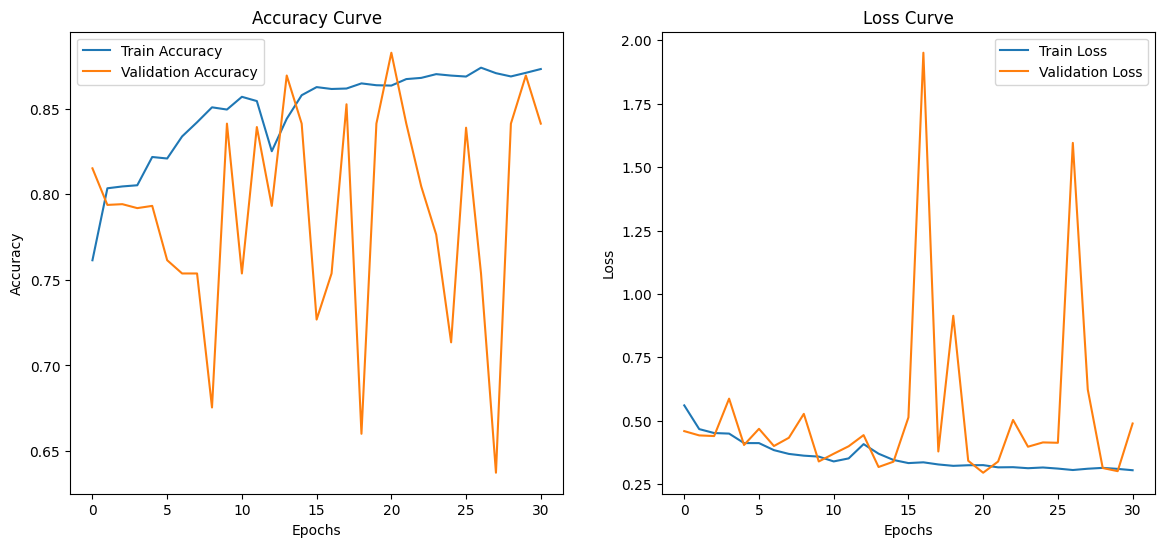


Confusion Matrix:


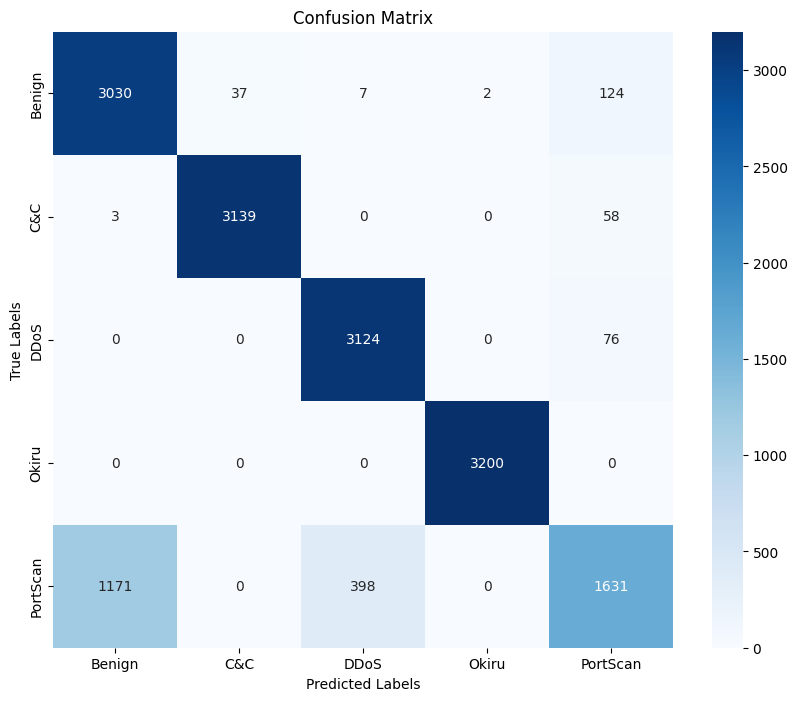


Classification Report:
              precision    recall  f1-score   support

      Benign       0.72      0.95      0.82      3200
         C&C       0.99      0.98      0.98      3200
        DDoS       0.89      0.98      0.93      3200
       Okiru       1.00      1.00      1.00      3200
    PortScan       0.86      0.51      0.64      3200

    accuracy                           0.88     16000
   macro avg       0.89      0.88      0.87     16000
weighted avg       0.89      0.88      0.87     16000



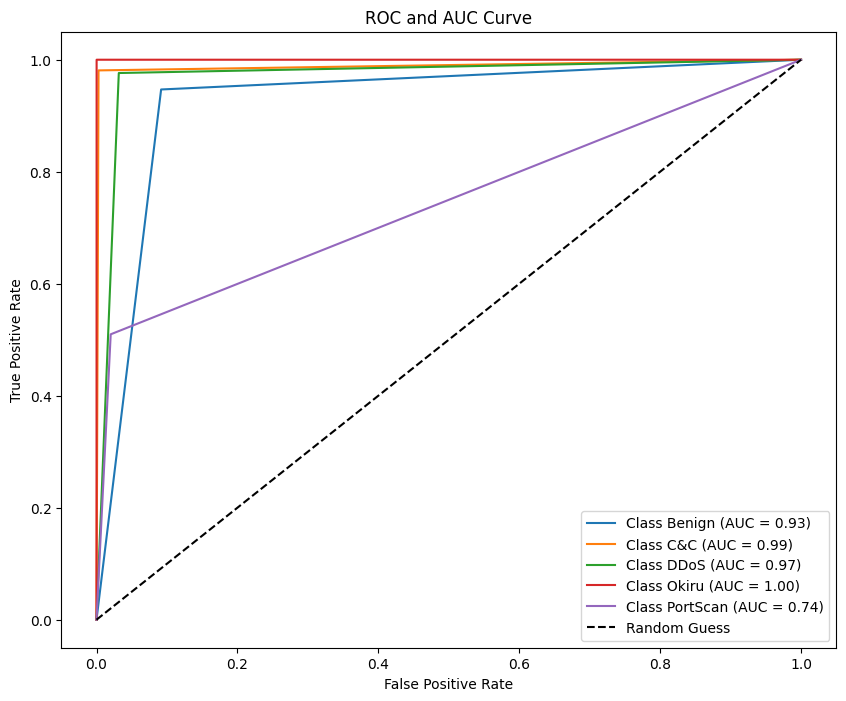


Random Predictions:
True Label: PortScan, Predicted: Benign
True Label: PortScan, Predicted: Benign
True Label: Benign, Predicted: Benign
True Label: Okiru, Predicted: Okiru
True Label: DDoS, Predicted: DDoS
True Label: Okiru, Predicted: Okiru
True Label: PortScan, Predicted: Benign
True Label: C&C, Predicted: C&C
True Label: Okiru, Predicted: Okiru
True Label: DDoS, Predicted: DDoS

Precision: 0.8914
Recall: 0.8828
F1 Score: 0.8745


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_fscore_support
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Step 1: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    image_dataset, image_labels, test_size=0.2, random_state=42, stratify=image_labels
)

# Step 2: Define the CNN model for 2x3 images
def build_cnn_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape, name="Input")

    # Convolutional Layers
    x = Conv2D(32, (1, 1), activation='relu', padding='same', name="Conv2D_32_1")(input_layer)
    x = BatchNormalization(name="BatchNorm_32_1")(x)
    x = Conv2D(64, (2, 2), activation='relu', padding='valid', name="Conv2D_64")(x)
    x = BatchNormalization(name="BatchNorm_64")(x)

    # Flatten and Fully Connected Layers
    x = Flatten(name="Flatten")(x)
    x = Dense(128, activation='relu', name="Dense_128")(x)
    x = BatchNormalization(name="BatchNorm_128")(x)
    x = Dropout(0.3, name="Dropout_128")(x)

    # Output Layer
    output_layer = Dense(num_classes, activation='softmax', name="Classifier_Output")(x)

    model = Model(inputs=input_layer, outputs=output_layer, name="Optimized_CNN_Classifier")
    return model


# Get input shape and number of classes
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

# Build and compile the model
model = build_cnn_model(input_shape, num_classes)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary and parameter count
model.summary()

# Step 3: Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Step 4: Train the model with progress bar
print("\nTraining the model:")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Step 5: Evaluate the model
evaluation = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {evaluation[1] * 100:.2f}%")
print(f"Test Loss: {evaluation[0]:.4f}")

# Step 6: Plot accuracy and loss curves
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Step 7: Predictions and Confusion Matrix
y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\nConfusion Matrix:")
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'C&C', 'DDoS', 'Okiru', 'PortScan'],
            yticklabels=['Benign', 'C&C', 'DDoS', 'Okiru', 'PortScan'])
plt.title("Confusion Matrix")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()

# Step 8: Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Benign', 'C&C', 'DDoS', 'Okiru', 'PortScan']))

# Step 9: ROC and AUC Curve
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve((y_test == i).astype(int), (y_pred == i).astype(int))
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {['Benign', 'C&C', 'DDoS', 'Okiru', 'PortScan'][i]} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title("ROC and AUC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Step 10: Random Predictions
print("\nRandom Predictions:")
random_indices = np.random.choice(len(X_test), size=10, replace=False)
for idx in random_indices:
    print(f"True Label: {['Benign', 'C&C', 'DDoS', 'Okiru', 'PortScan'][y_test[idx]]}, "
          f"Predicted: {['Benign', 'C&C', 'DDoS', 'Okiru', 'PortScan'][y_pred[idx]]}")

# Step 11: Precision, Recall, and F1 Score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
